In [1]:
from __future__ import print_function
import sdm as sdmlib
import matplotlib.pyplot as plt

In [2]:
bits = 1000
radius = 451 #utils.calculate_radius(bits)
sample = 1000000
scanner_type = sdmlib.SDM_SCANNER_OPENCL

In [3]:
address_space = sdmlib.AddressSpace.init_random(bits, sample)
counter = sdmlib.Counter.init_zero(bits, sample)
sdm = sdmlib.SDM(address_space, counter, radius, scanner_type)

In [4]:
def write(n=1000, prefix=''):
    print('{}Writing {} random bitstrings... '.format(prefix, n), end='')
    for i in range(n):
        if i%20 == 0:
          print('!', end='')
        
        b1 = sdmlib.Bitstring.init_random(bits)
        b2 = sdmlib.Bitstring.init_random(bits)
        sdm.write(b1, b2)
    print('')
    return n

In [5]:
write(10000)

Writing 10000 random bitstrings... !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


10000

In [6]:
v1 = []
for i in range(sample):
    bs1 = address_space.get_bitstring(i)
    bs2 = counter.to_bitstring(i)
    v1.append(bits - bs1.distance_to(bs2))

499.997162 15.8135793528
636.219421439 15.2132925175


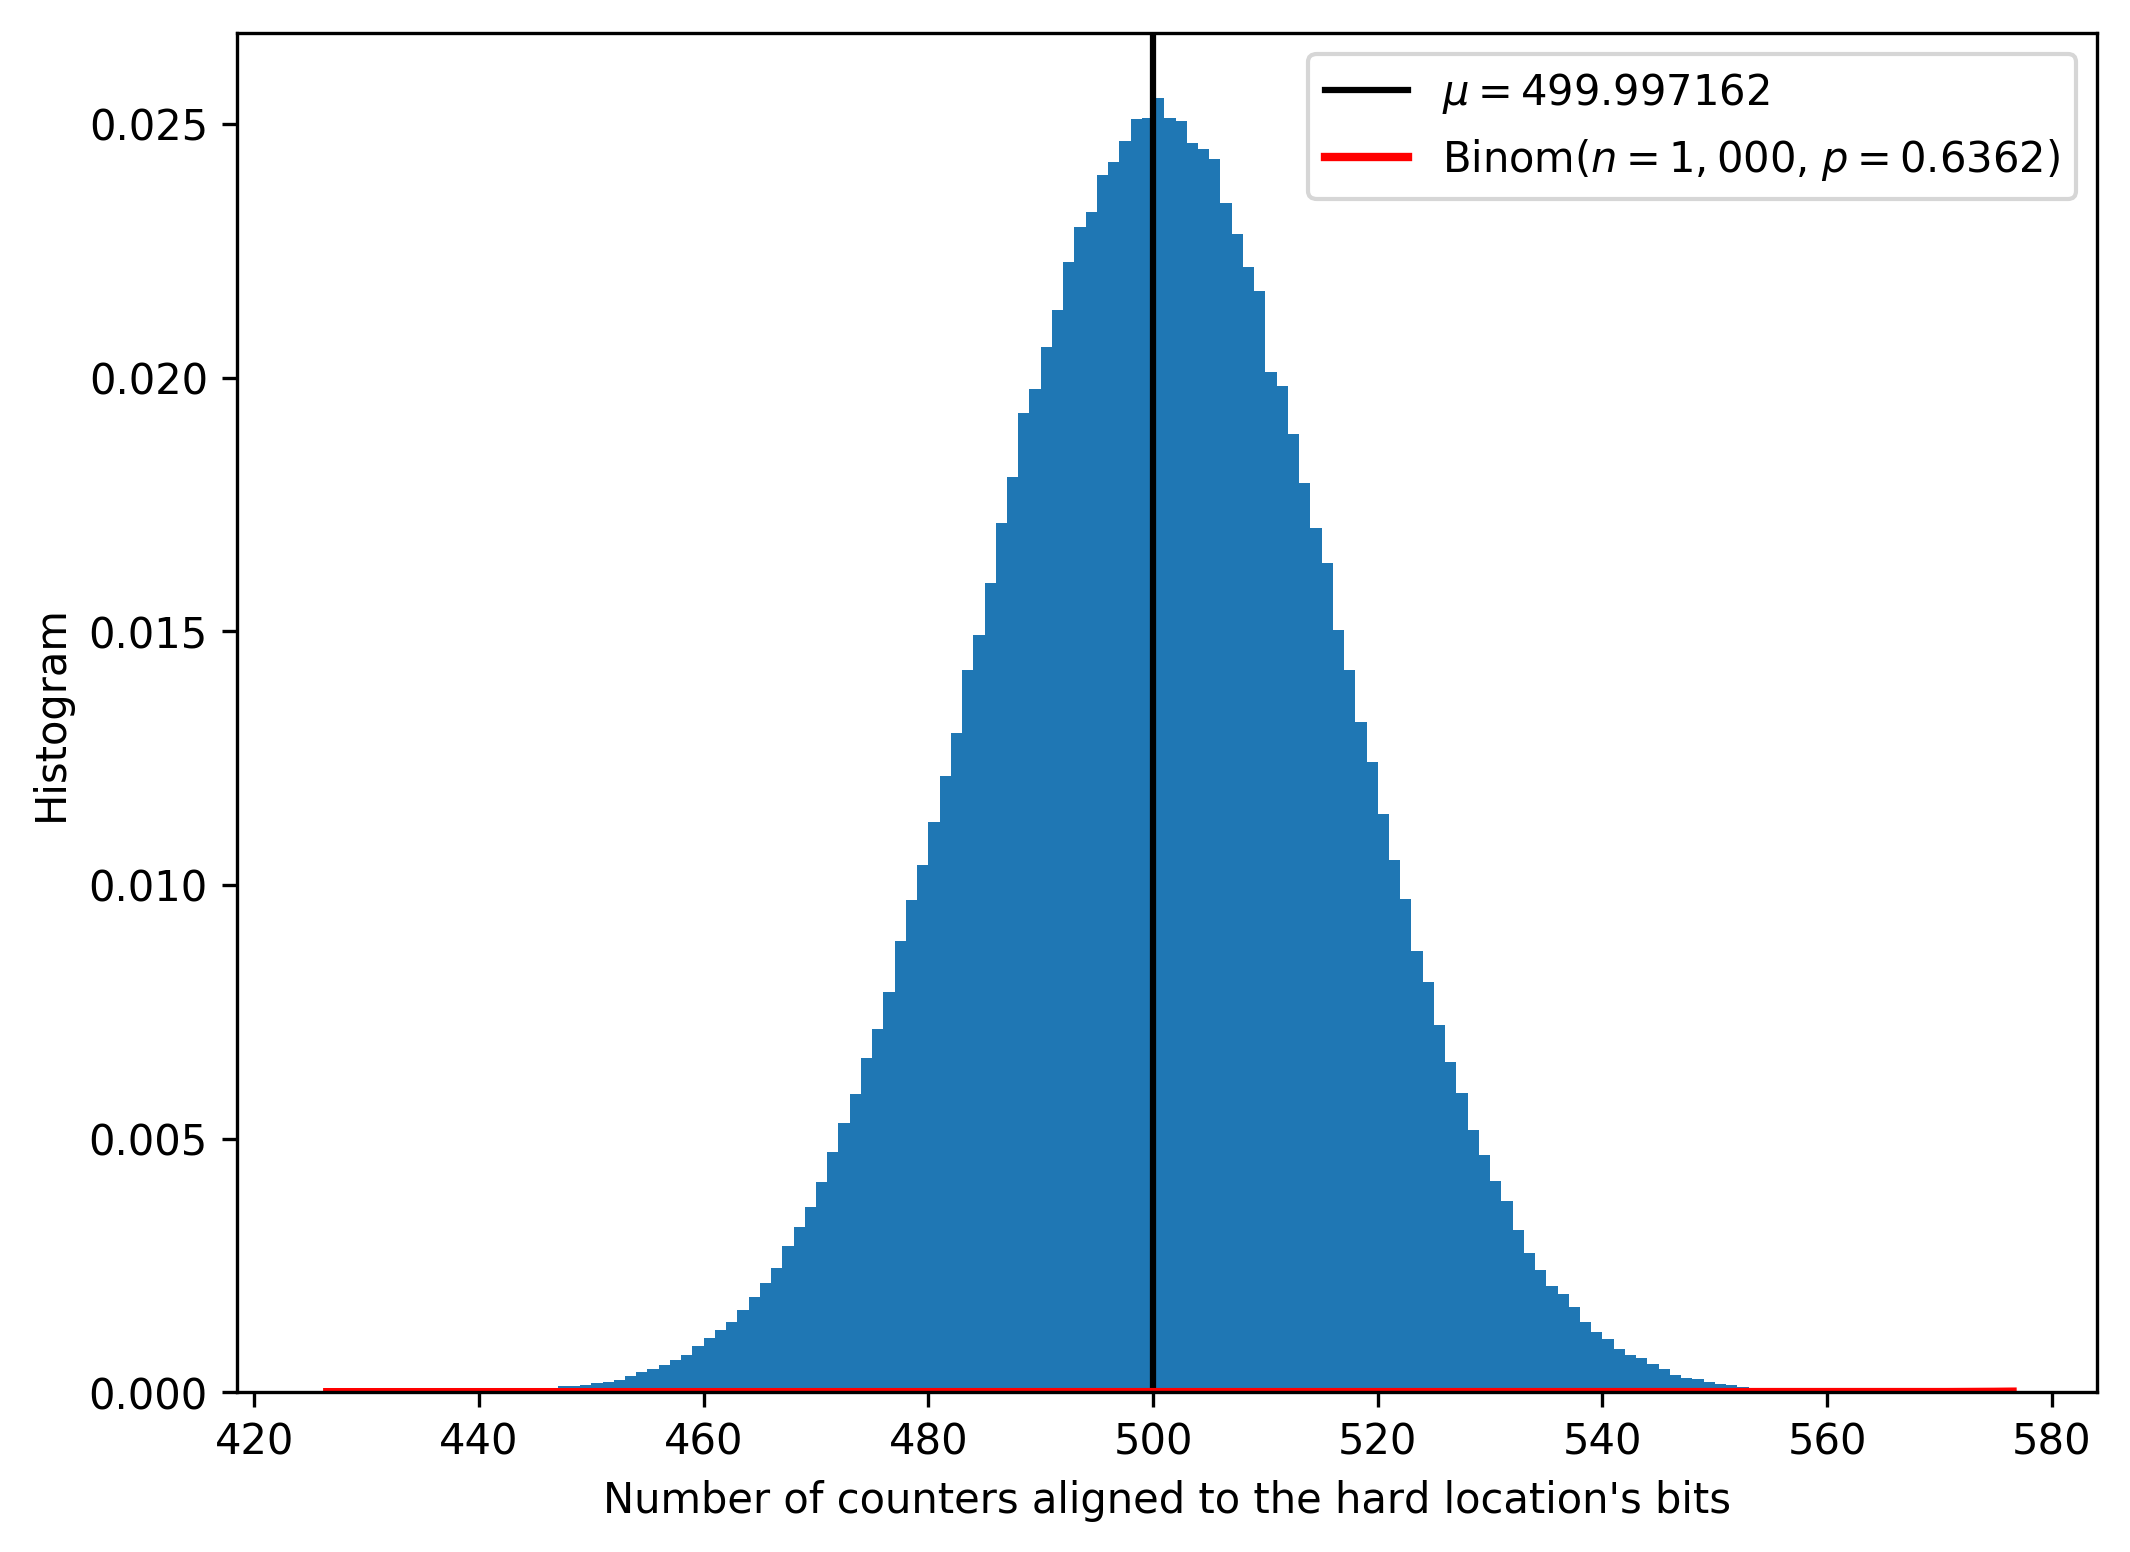

In [9]:
plt.figure(figsize=(8, 6), dpi=300)
bins = plt.hist(v1, bins=range(min(v1), max(v1)+1), density=True);
mu = 1.0*sum(v1)/len(v1)
sigma = (sum((x - mu)**2 for x in v1)/len(v1))**0.5

p = 0.36378057856128687
plt.axvline(mu, color='k', label='$\mu = {}$'.format(mu))
plt.xlabel('Number of counters aligned to the hard location\'s bits')
plt.ylabel('Histogram')
#plt.xlim(500, 780)

print(mu, sigma)

p = 1-0.36378057856128687
mu = p*1000
sigma = (p*(1-p)*1000)**0.5
print(mu, sigma)

import numpy as np
import matplotlib.mlab as mlab
#from scipy.stats import binom
x_values = np.linspace(min(v1), max(v1)+1, 1000)
y_values = mlab.normpdf(x_values, mu, sigma)
#x_values = list(range(min(v1), max(v1)+1))
#y_values = binom.pmf(x_values, 1000, p)
plt.plot([x+0.5 for x in x_values], y_values, 'r', linewidth=2.0, label='Binom($n=1,000$, $p={:.4f}$)'.format(p))
plt.legend()

In [10]:
v2 = []
bs1 = sdmlib.Bitstring.init_zeros(bits)
for i in range(sample):
    bs2 = address_space.get_bitstring(i)
    v2.append(bs1.distance_to(bs2))

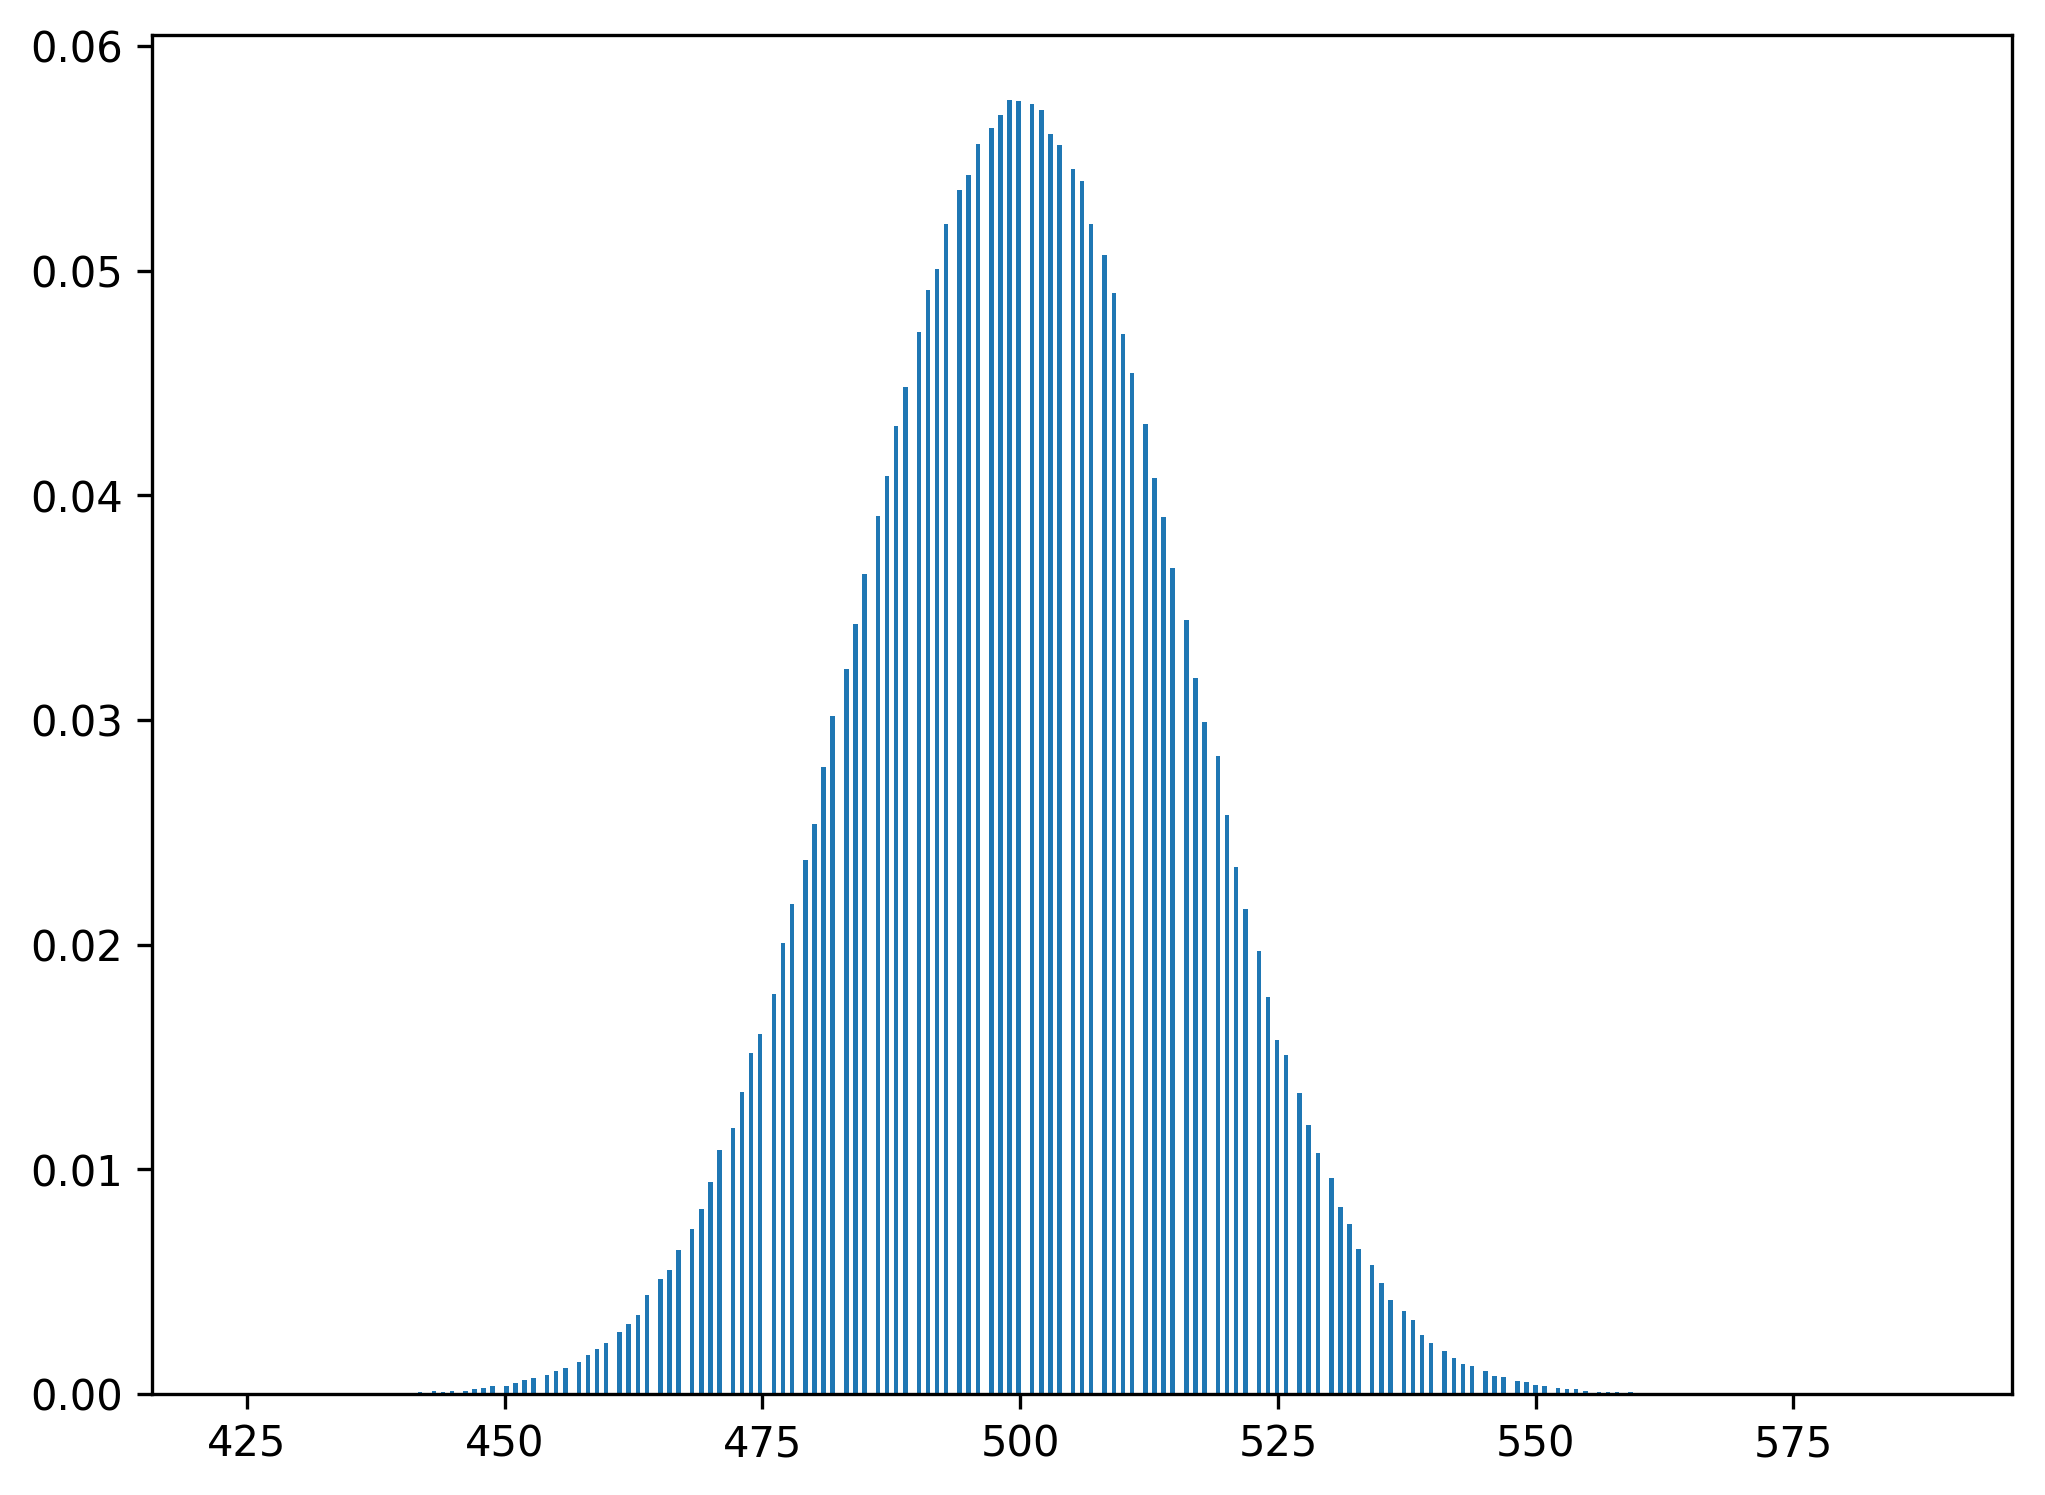

In [11]:
plt.figure(figsize=(8, 6), dpi=300)
plt.hist(v2, bins='fd', density=True);

In [12]:
v3 = []
for _ in range(100):
    bs1 = sdmlib.Bitstring.init_random(bits)
    selected = address_space.scan_opencl2(bs1, radius)
    for idx in selected:
        bs2 = address_space.get_bitstring(idx)
        v3.append(bs1.distance_to(bs2))

447.10771449841803

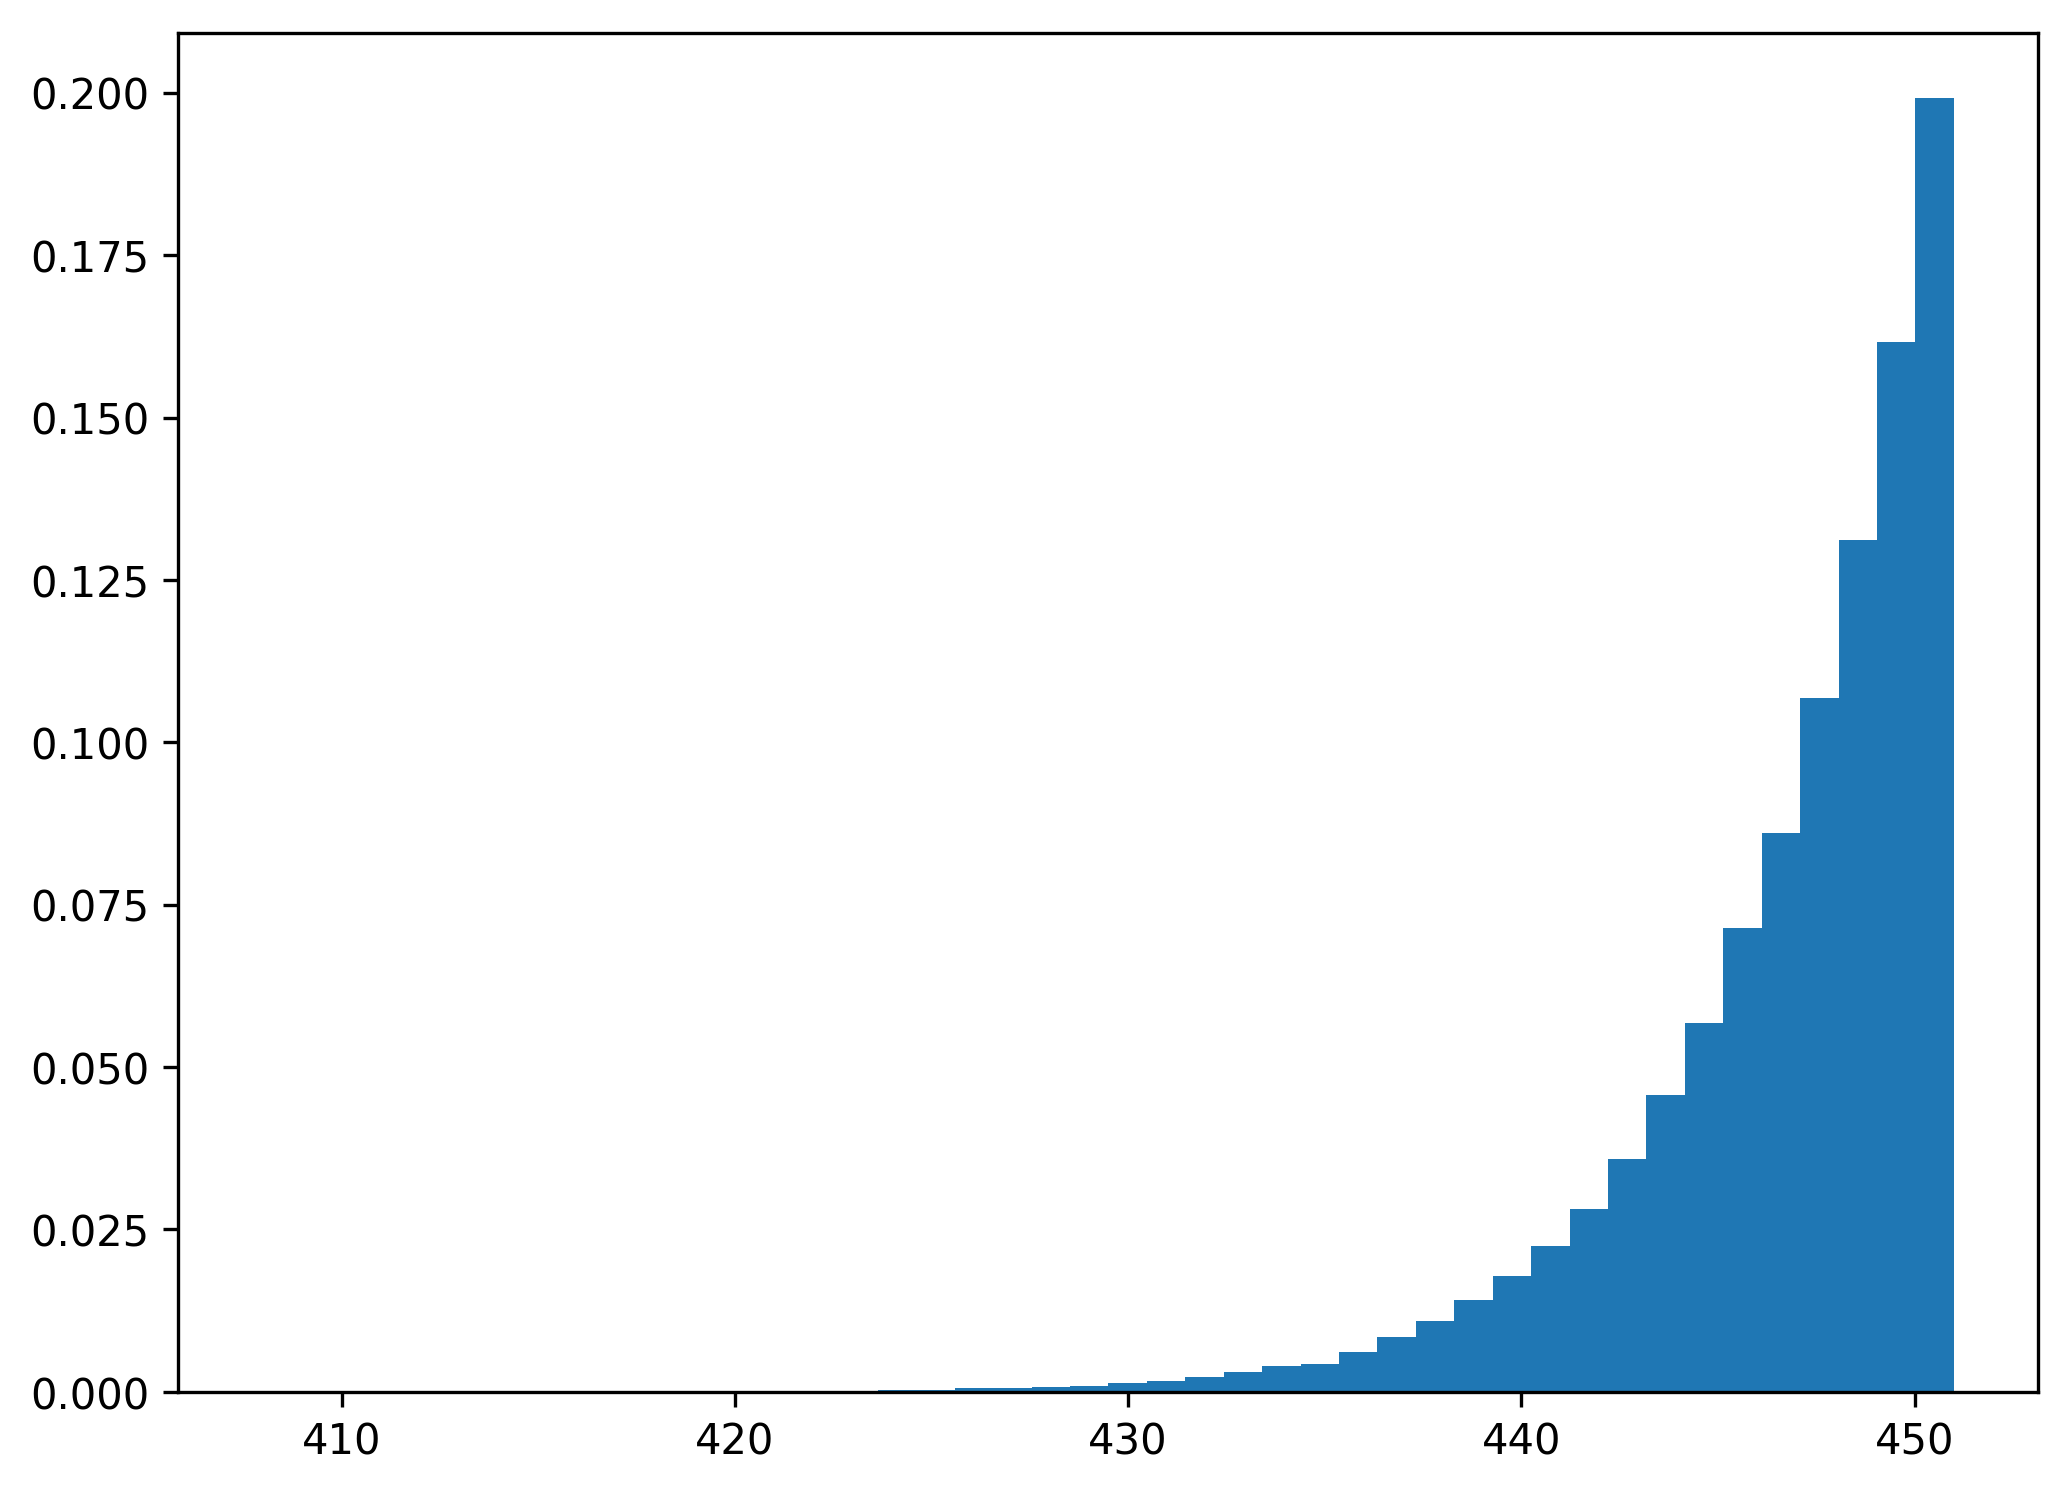

In [13]:
plt.figure(figsize=(8, 6), dpi=300)
plt.hist(v3, bins=max(v3)-min(v3)+1, density=True);
1.0*sum(v3)/len(v3)

In [14]:
from math import factorial, log, exp
binom = lambda a, b: factorial(a) // factorial(b) // factorial(a - b)
a = sum(binom(bits-1, k) for k in range(0, radius+1))
b = sum(binom(bits, k) for k in range(0, radius+1))
#print(a)
#print(b)
prob_xi_yi = 1.0*a/b
print(prob_xi_yi)

0.552905498137


In [15]:
v4 = []
for i in range(1000):
    bs1 = address_space.get_bitstring(i)
    cnt1 = counter.get_counter(i)
    for j in range(bits):
        if bs1.get_bit(j) == 0:
            v4.append(cnt1[j])

0.00294428900131
1.13413516356
0.6362194214388819


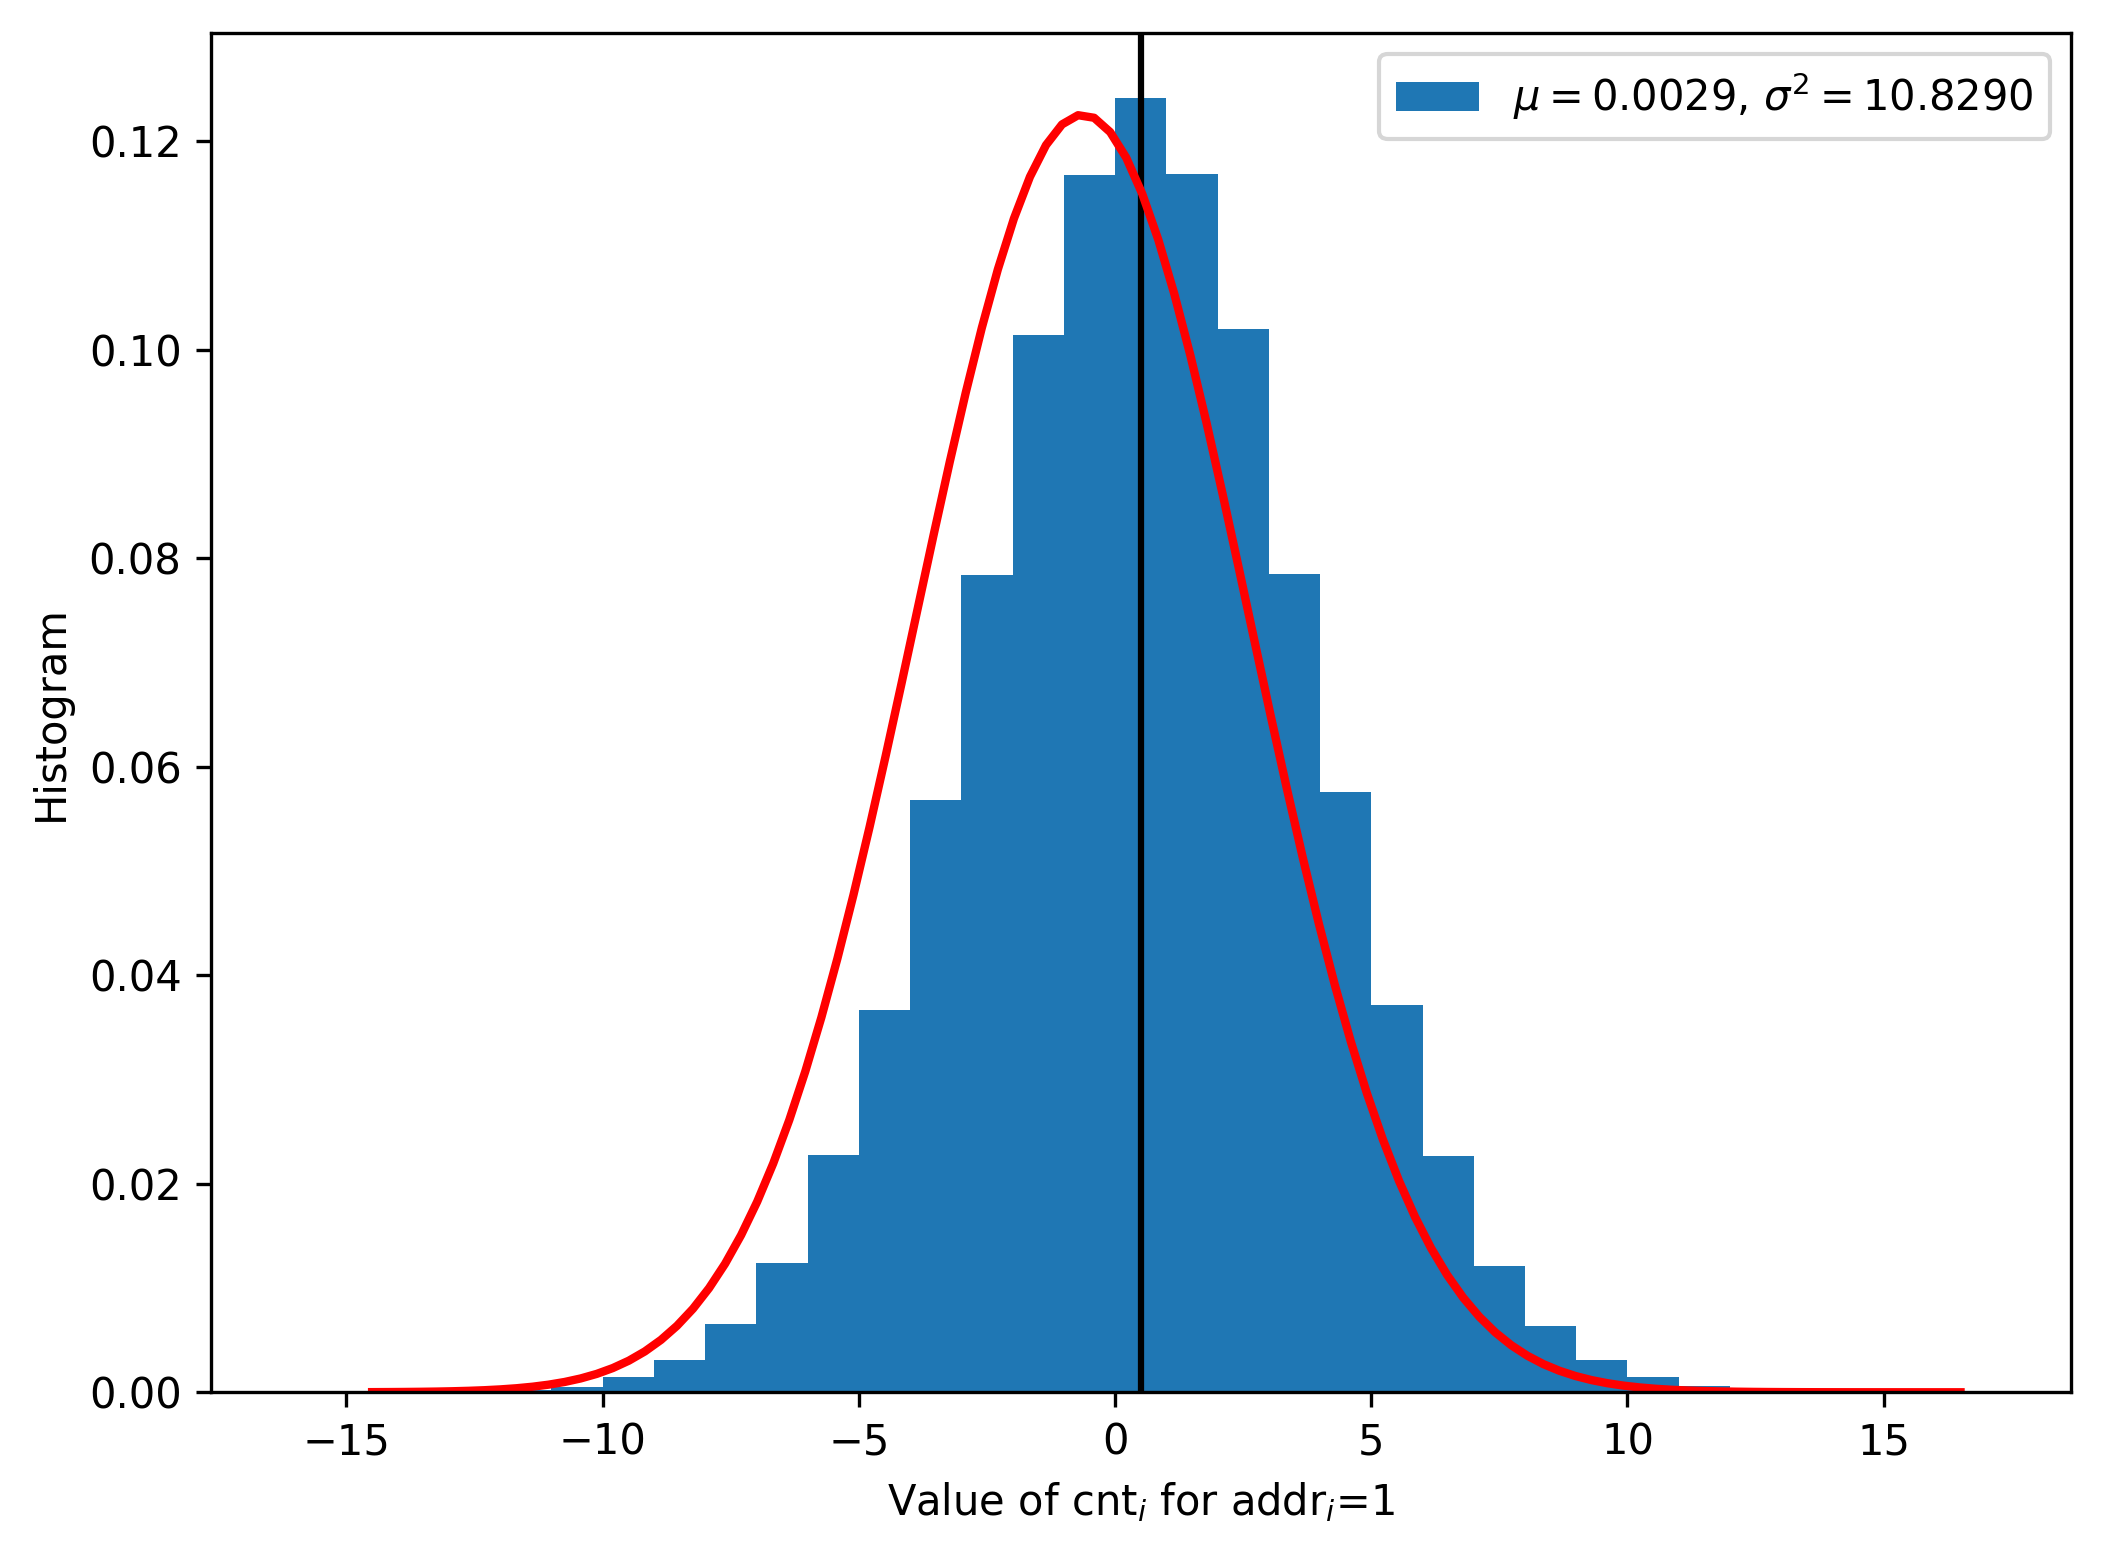

In [16]:
plt.figure(figsize=(8, 6), dpi=300)


mu = 1.0*sum(v4)/len(v4)
var = sum((x-mu)**2 for x in v4)/len(v4)
bins = plt.hist(v4, bins=range(min(v4), max(v4)+1), density=True, label='$\mu = {:.4f}$, $\sigma^2 = {:.4f}$'.format(mu, var));
print(1.0*sum(v4)/len(v4))
print((2*prob_xi_yi-1) * 10000 * 1071.85 / 1000000)

plt.axvline(mu+0.5, color='k')
plt.xlabel('Value of cnt$_i$ for addr$_i$=1')
plt.ylabel('Histogram')

number_of_bs_per_hl = 10000 * 1071.85 / 1000000
mu = -(2*prob_xi_yi - 1) * number_of_bs_per_hl
sigma = 2 * (prob_xi_yi * (1 - prob_xi_yi) * number_of_bs_per_hl)**0.5

import numpy as np
import matplotlib.mlab as mlab
from scipy import stats
x_values = np.linspace(-15, 16, 100)
y_values = mlab.normpdf(x_values, mu, sigma)
plt.plot([x+0.5 for x in x_values], y_values, 'r', linewidth=2.0);
print(stats.norm.cdf(0, mu, sigma))

plt.legend()

In [17]:
prob_xi_yi

0.5529054981370675

In [18]:
v5 = []
v6 = []
k = 0
while k < 2000:
    bs1 = sdmlib.Bitstring.init_random(bits)
    if bs1.get_bit(0) != 1:
        continue
    k += 1
    selected = address_space.scan_opencl2(bs1, radius)
    acc = 0
    cnt = 0
    for idx in selected:
        bs2 = address_space.get_bitstring(idx)
        if bs2.get_bit(0) == 0:
            cnt += 1
            acc += counter.counter[idx][0]
        #acc += counter.counter[idx][0]
    v5.append(acc)
    v6.append(1.0*cnt/len(selected))

52.4585
672.124515995
79.2527938648


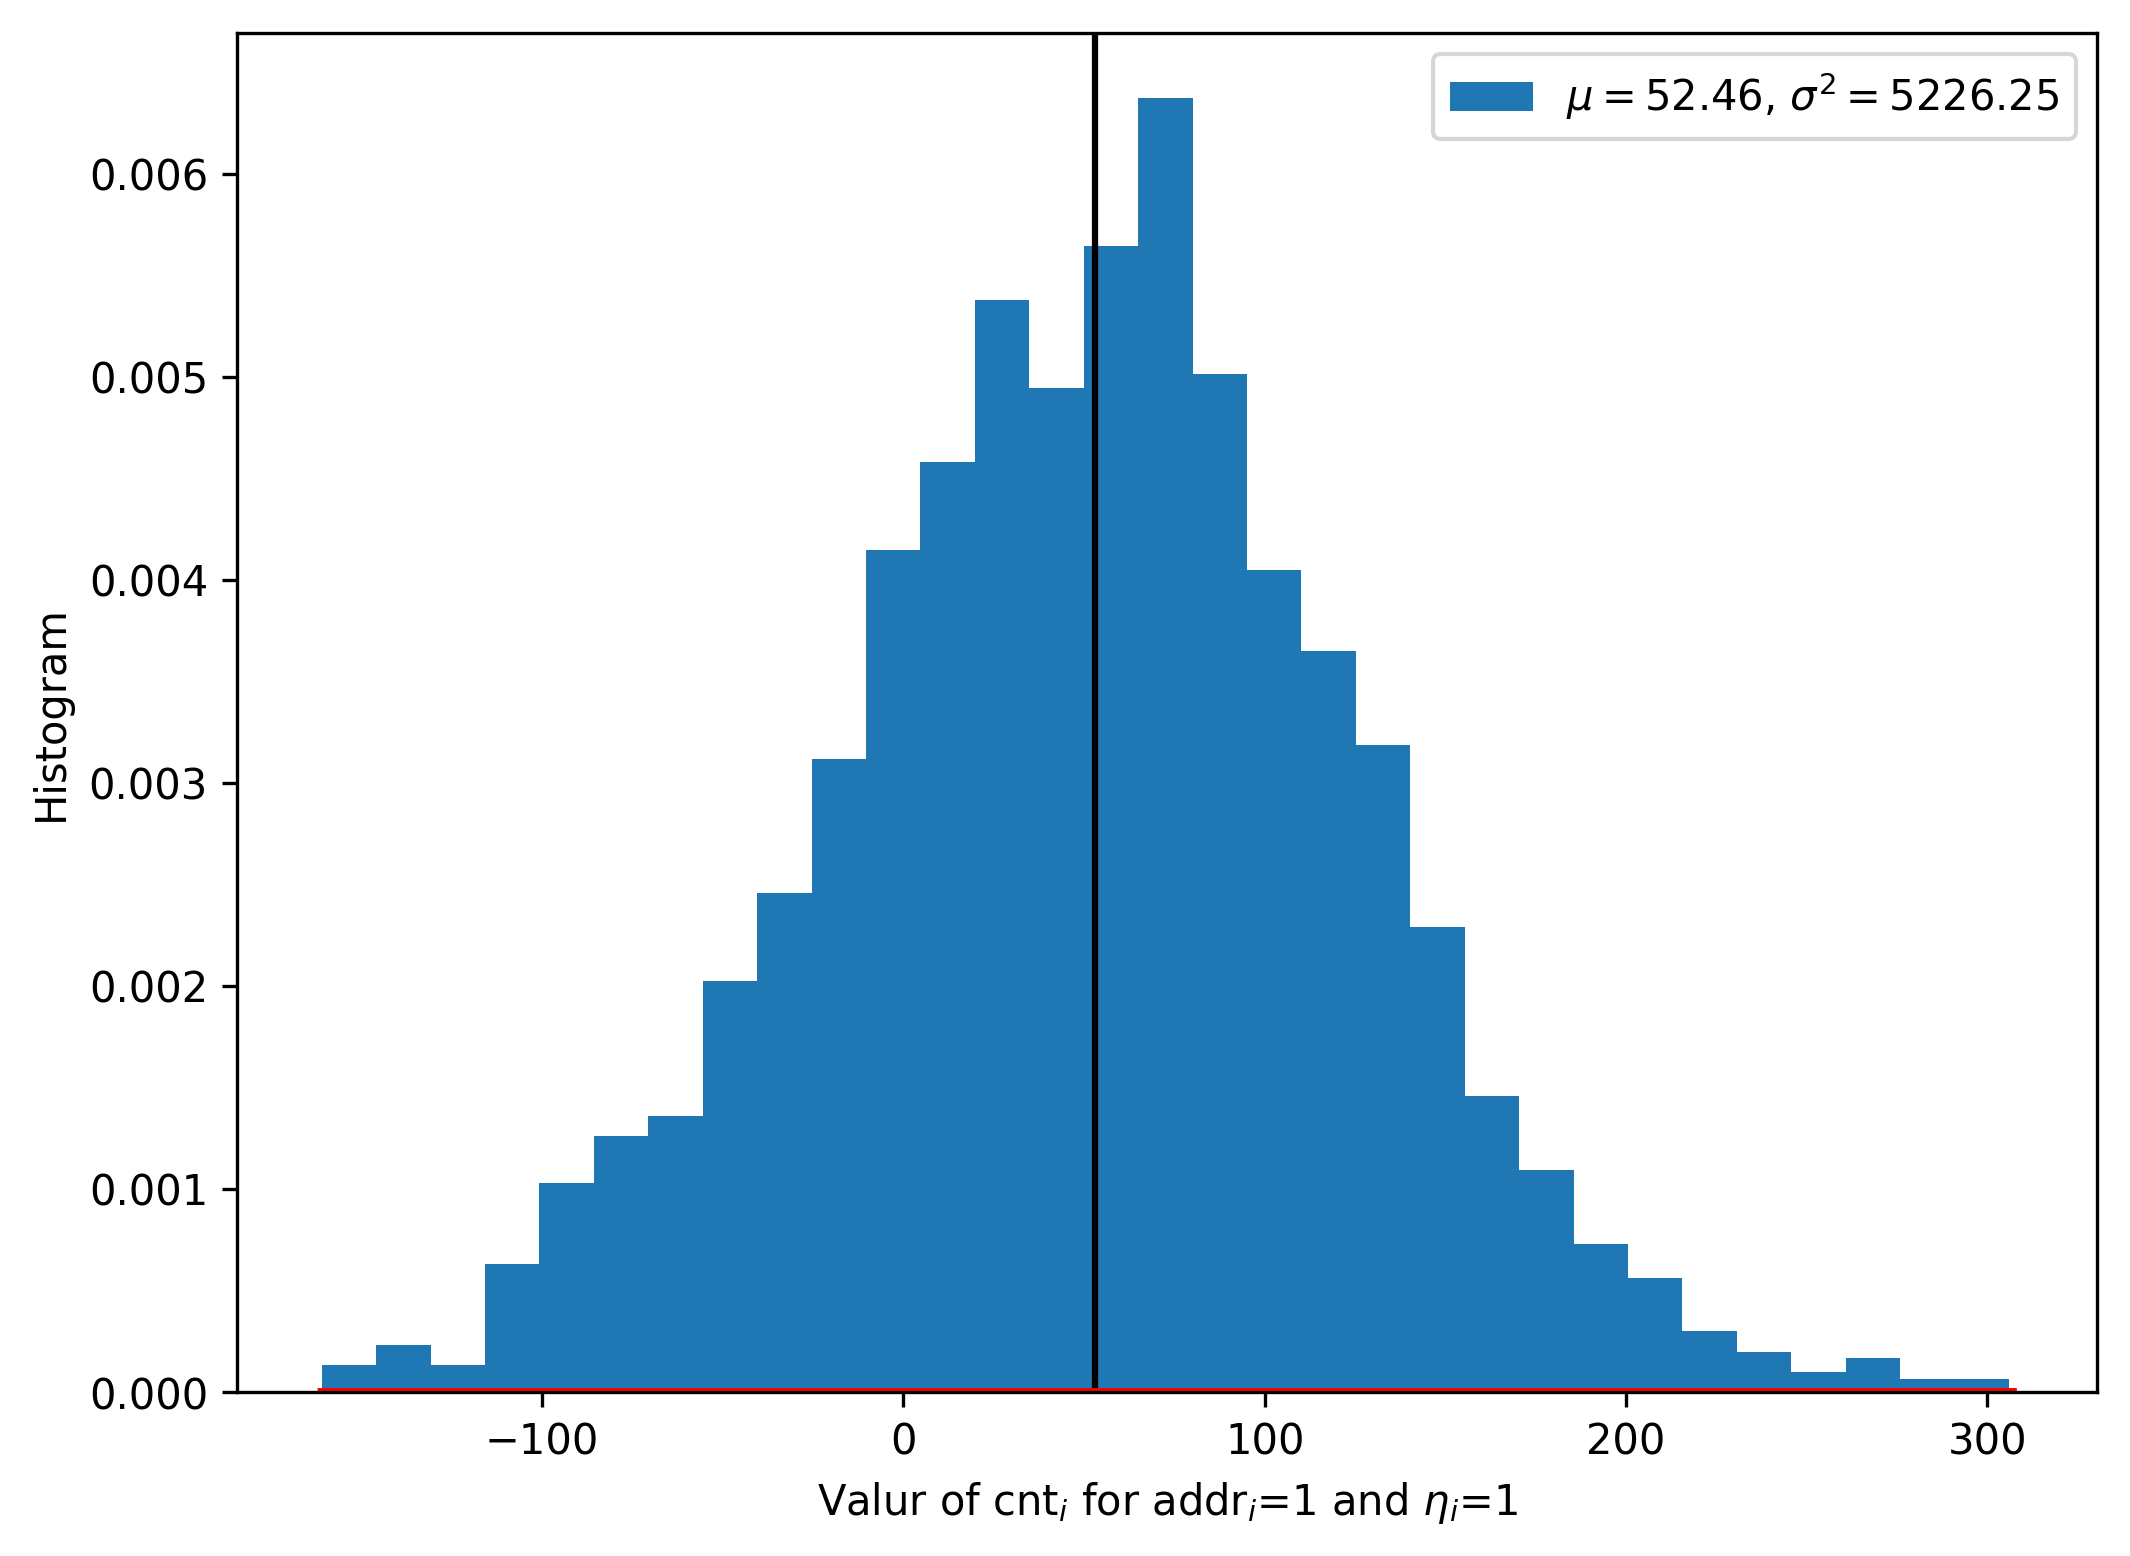

In [19]:
plt.figure(figsize=(8, 6), dpi=300)

mu = 1.0*sum(v5)/len(v5)
var = sum((x-mu)**2 for x in v5)/len(v5)
bins = plt.hist(v5, bins='fd', density=True, label='$\mu = {:.2f}$, $\sigma^2 = {:.2f}$'.format(mu, var));
print(mu)

plt.axvline(mu+0.5, color='k')
plt.ylabel('Histogram')

number_of_bs_per_hl = 10000 * 1071.85 / 1000000
probability = (2*prob_xi_yi-1)

if (mu > 0):
    # eta_i = 1, addr_i = 1
    mu = (2*prob_xi_yi-1) * number_of_bs_per_hl * ((prob_xi_yi) * 1071.85)
    sigma = 2 * (prob_xi_yi * (1 - prob_xi_yi) * number_of_bs_per_hl * (prob_xi_yi*1071.85))**0.5
    plt.xlabel('Valur of cnt$_i$ for addr$_i$=1 and $\eta_i$=1')

else:
    # eta_i = 1, addr_i = 0
    mu = -(2*prob_xi_yi-1) * number_of_bs_per_hl * ((1-prob_xi_yi) * 1071.85)
    sigma = 2 * (prob_xi_yi * (1 - prob_xi_yi) * number_of_bs_per_hl * ((1-prob_xi_yi)*1071.85))**0.5
    plt.xlabel('Valur of cnt$_i$ for addr$_i$=0 and $\eta_i$=1')



import numpy as np
import matplotlib.mlab as mlab
x_values = np.linspace(min(v5), max(v5)+1, 1000)
y_values = mlab.normpdf(x_values, mu, sigma)
plt.plot(x_values, y_values, 'r', linewidth=2.0);

print(mu)
print(sigma)
plt.legend()

0.447716619414


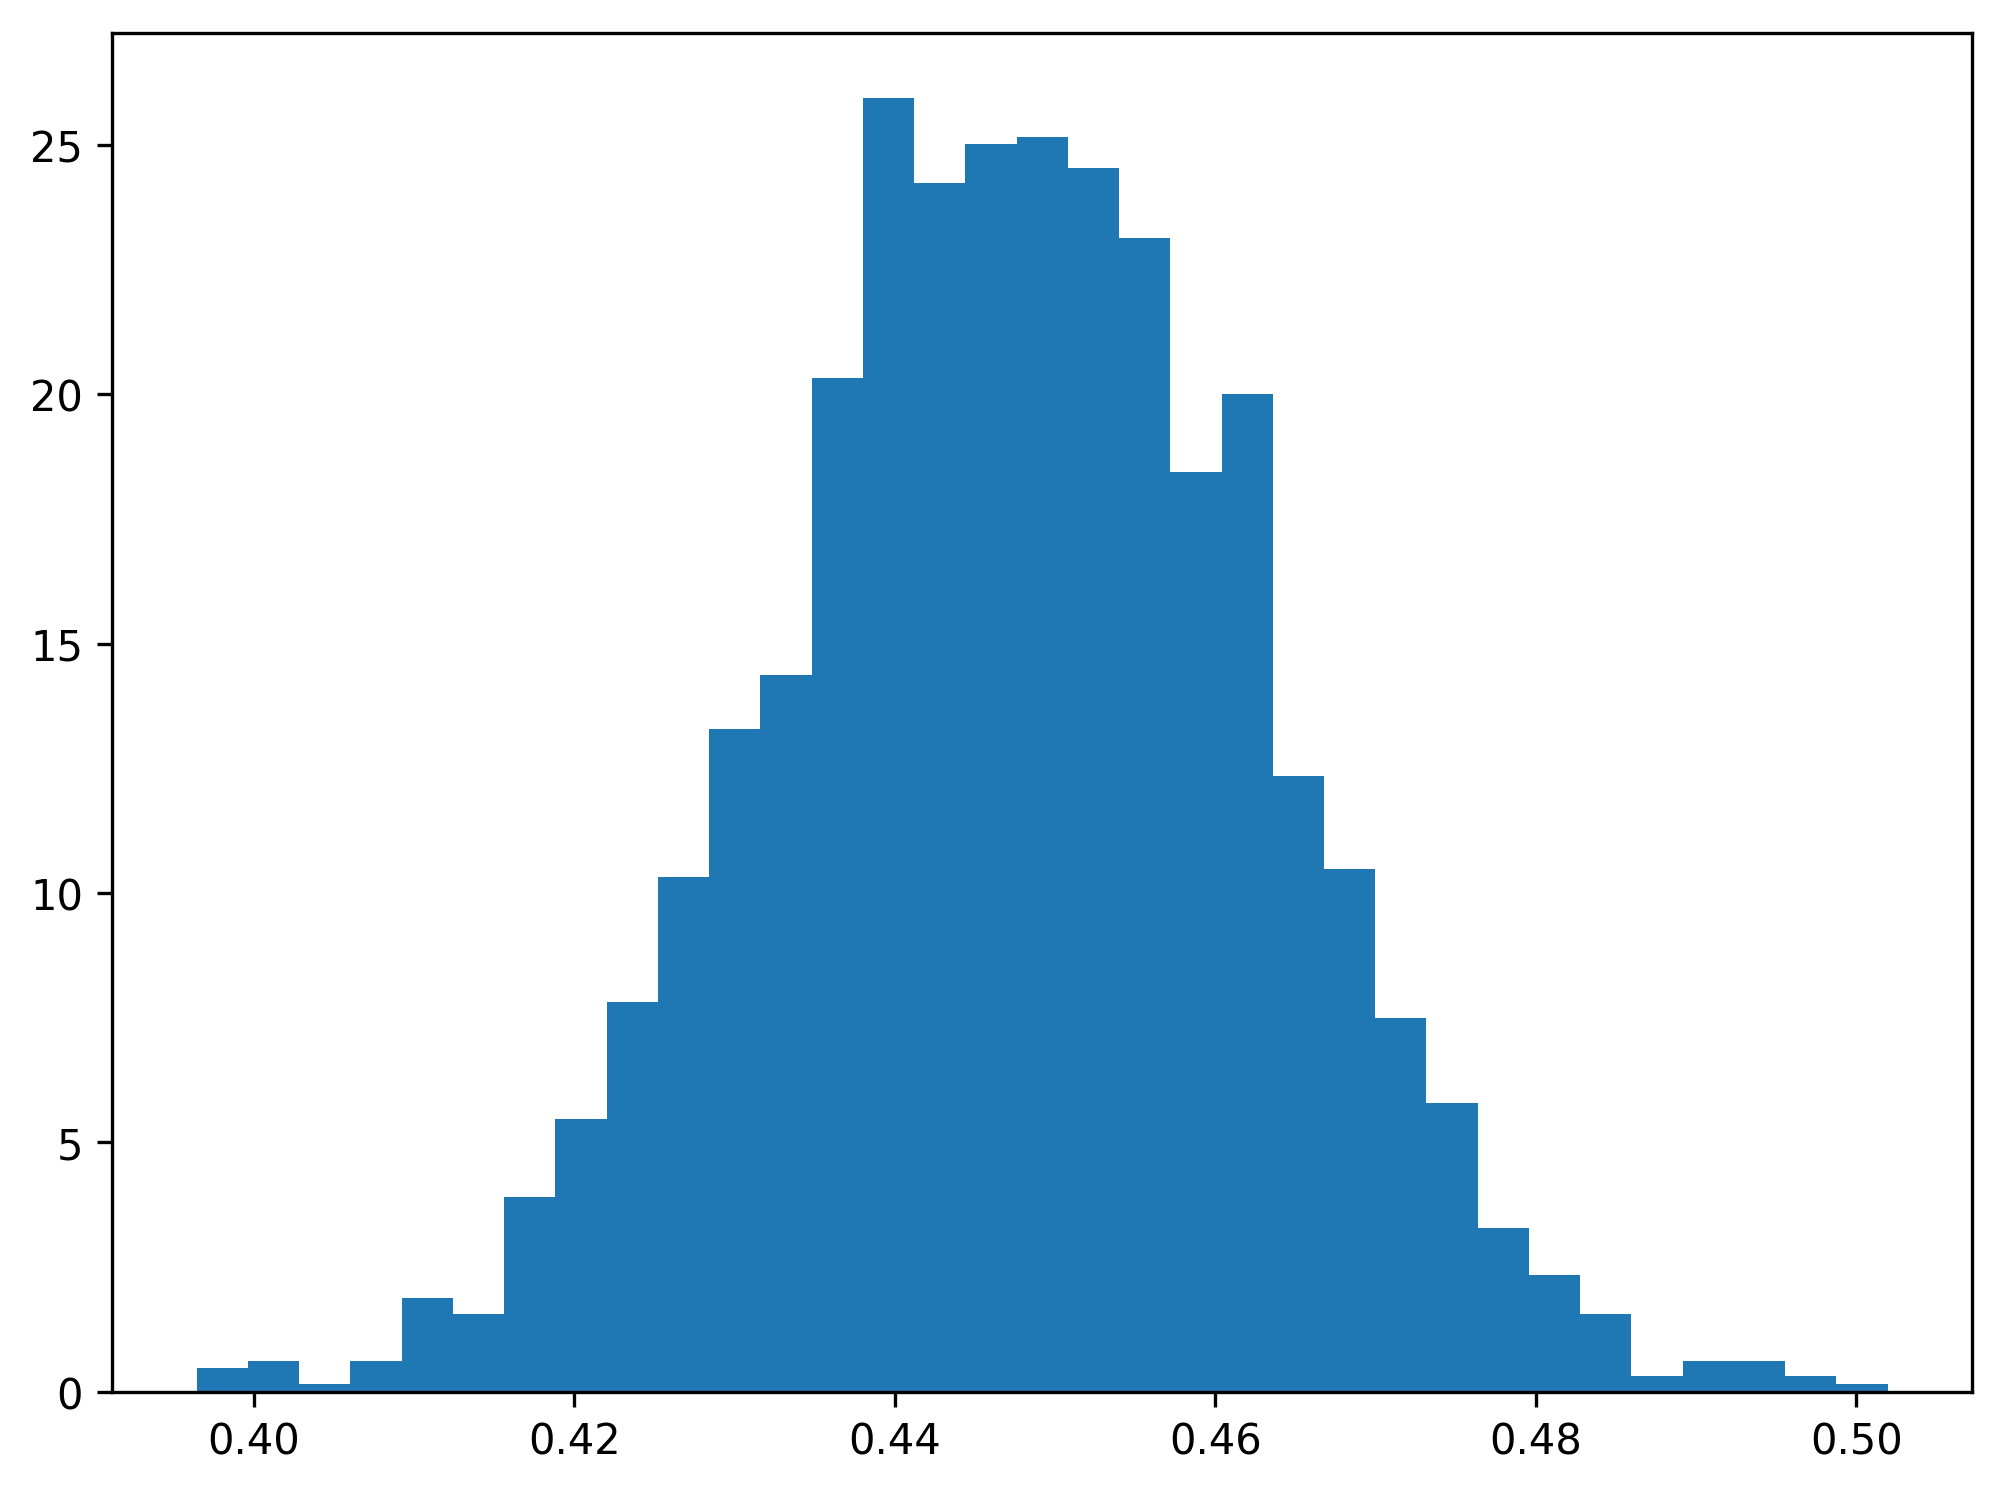

In [20]:
plt.figure(figsize=(8, 6), dpi=300)
plt.hist(v6, bins='fd', density=True);
print(sum(v6)/len(v6))

In [21]:
v7 = []
v8 = []
k = 0
while k < 2000:
    bs1 = sdmlib.Bitstring.init_random(bits)
    if bs1.get_bit(0) != 0:
        continue
    k += 1
    selected = address_space.scan_opencl2(bs1, radius)
    acc = 0
    cnt = 0
    for idx in selected:
        bs2 = address_space.get_bitstring(idx)
        acc += counter.counter[idx][0]
    v7.append(acc)
    v8.append(1.0*cnt/len(selected))

114.2
-128.626256923
106.583291224


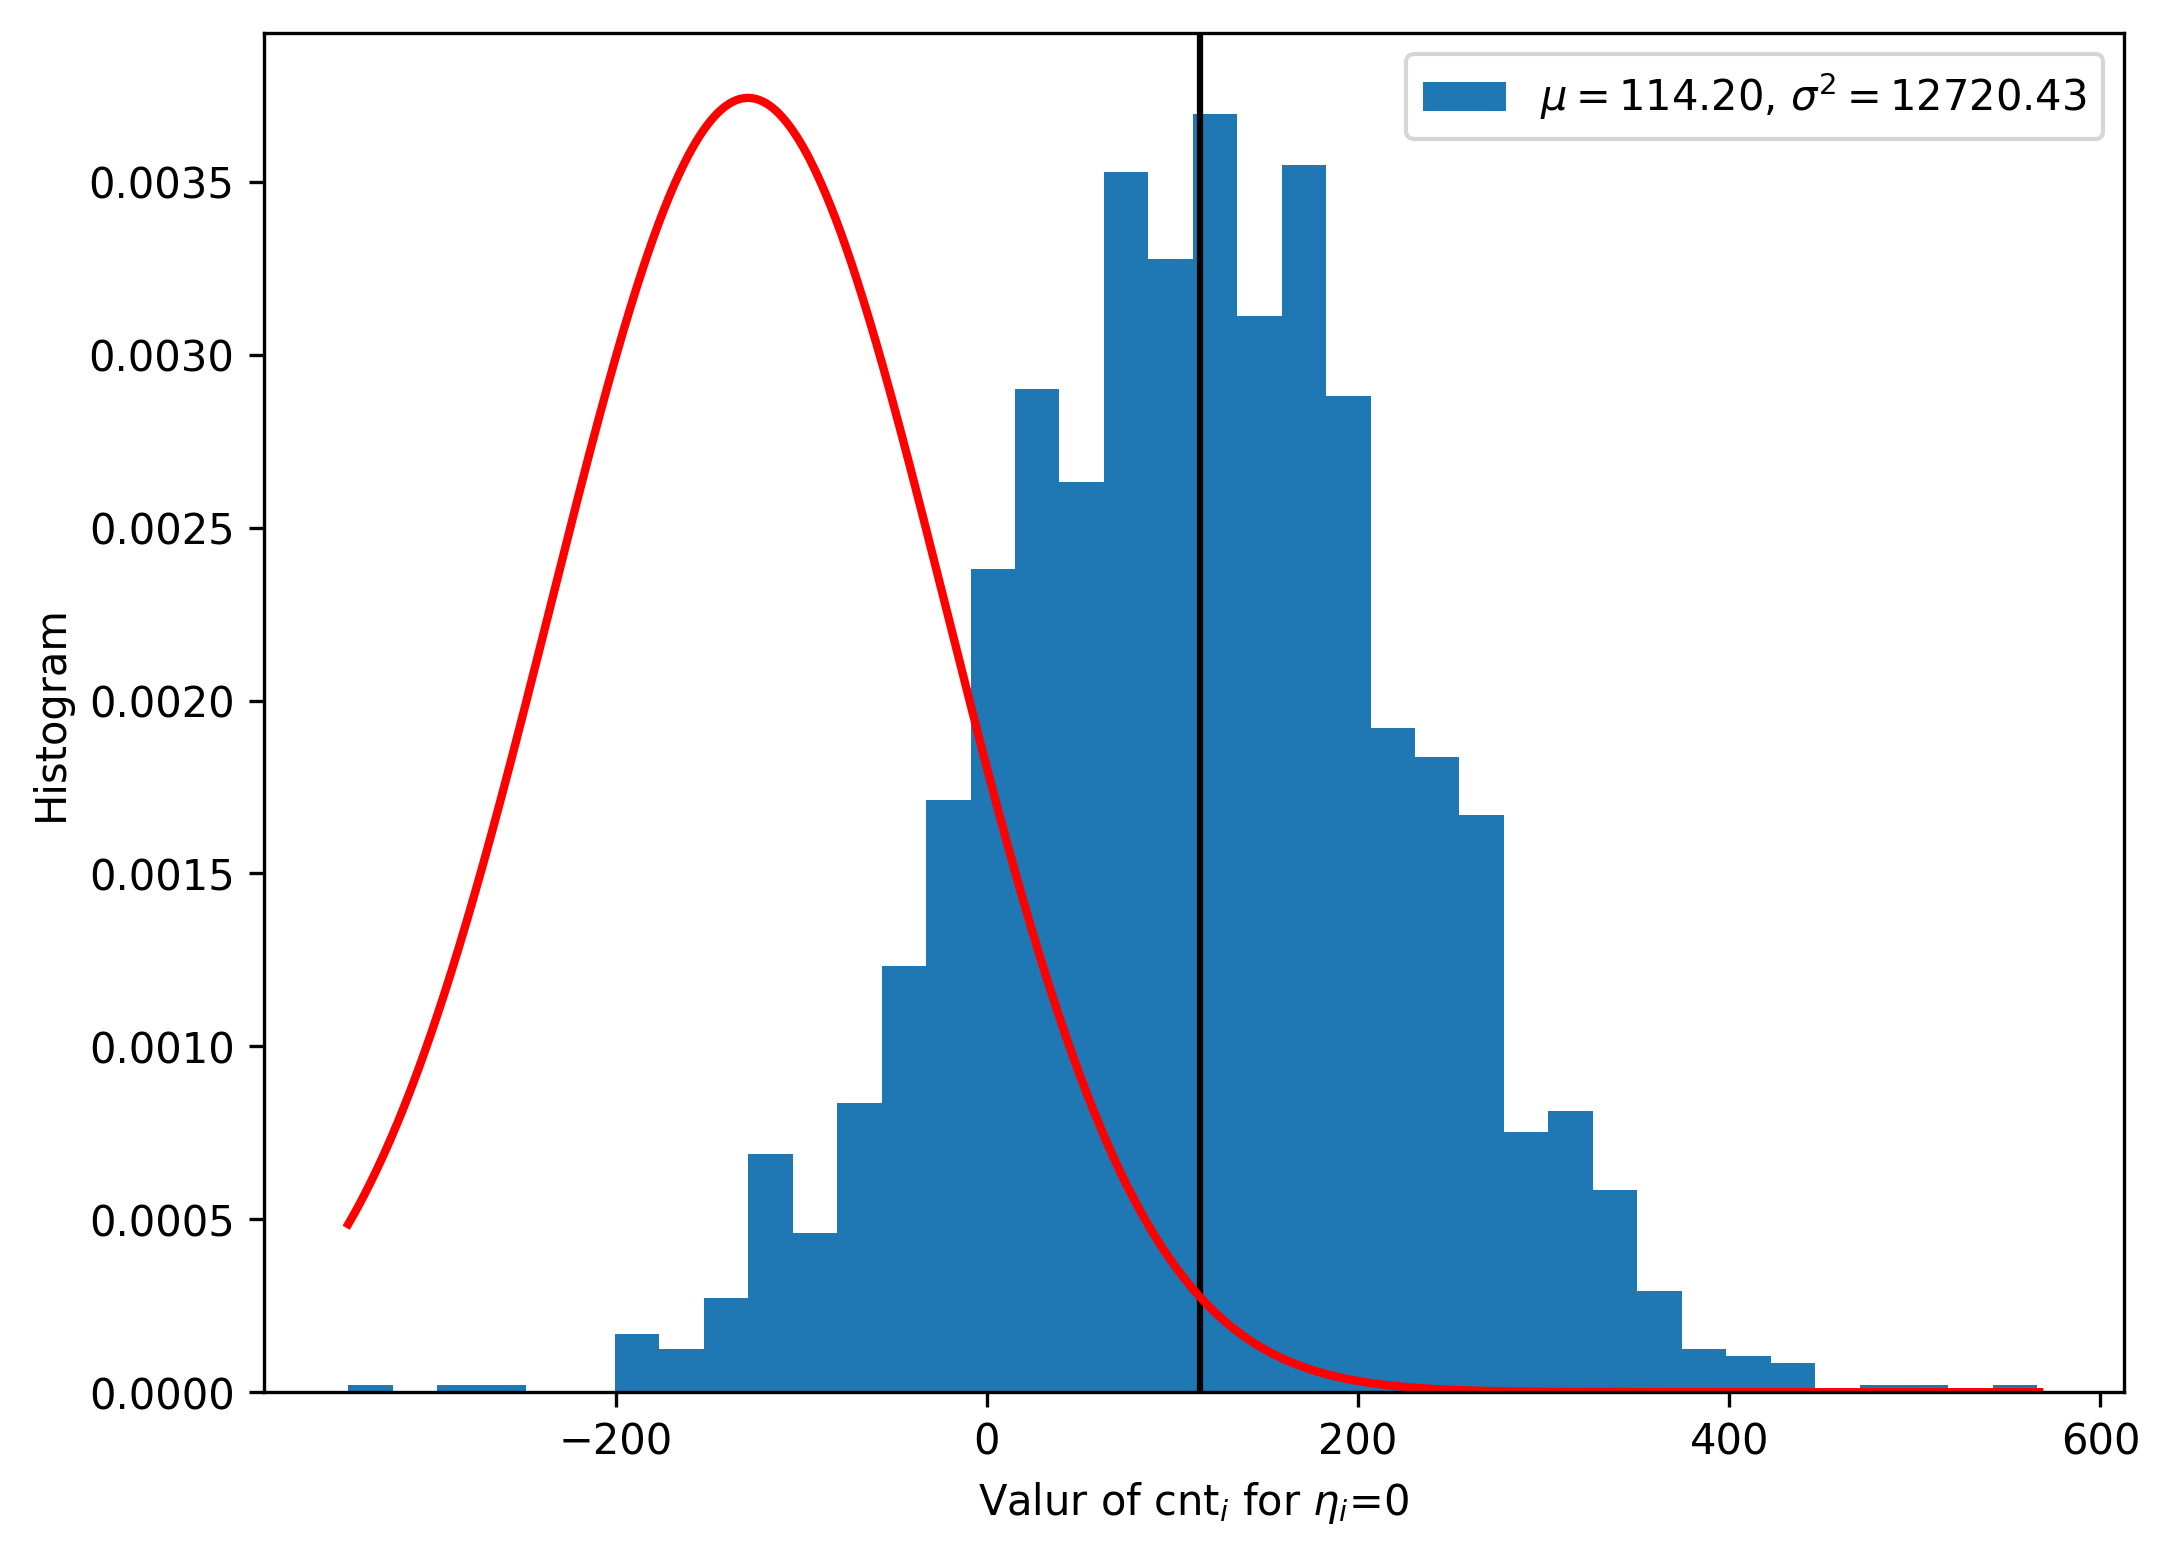

In [22]:
plt.figure(figsize=(8, 6), dpi=300)

mu = 1.0*sum(v7)/len(v7)
var = sum((x-mu)**2 for x in v7)/len(v7)
bins = plt.hist(v7, bins='fd', density=True, label='$\mu = {:.2f}$, $\sigma^2 = {:.2f}$'.format(mu, var));
print(mu)

plt.axvline(mu+0.5, color='k')
plt.ylabel('Histogram')

number_of_bs_per_hl = 10000 * 1071.85 / 1000000
probability = (2*prob_xi_yi-1)

mu = -(2*prob_xi_yi-1) * number_of_bs_per_hl * ((2*prob_xi_yi-1) * 1071.85)
sigma = 2 * (prob_xi_yi * (1 - prob_xi_yi) * number_of_bs_per_hl * (1071.85))**0.5
plt.xlabel('Valur of cnt$_i$ for $\eta_i$=0')

import numpy as np
import matplotlib.mlab as mlab
x_values = np.linspace(min(v7), max(v7)+1, 1000)
y_values = mlab.normpdf(x_values, mu, sigma)
plt.plot(x_values, y_values, 'r', linewidth=2.0);

print(mu)
print(sigma)
plt.legend()

In [ ]:
sum(x for x, y in zip(bins[0], bins[1]))